<a href="https://colab.research.google.com/github/dauparas/ProteinMPNN/blob/main/colab_notebooks/quickdemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ProteinMPNN
This notebook was adapted from https://github.com/dauparas/ProteinMPNN/tree/main/colab_notebooks to do a stepwise calculation of conditional probabilities for each surface accessible position

In [2]:
#script adapted from https://github.com/dauparas/ProteinMPNN/tree/main/colab_notebooks

import json, time, os, sys, glob

# Set the base directory for the 'proteinMPNN' package
base='/path/to/PMPNN' # Replace '/path/to/PMPNN' with the actual path
sys.path.append(base)

In [3]:
# Function to generate a dictionary with fixed positions for each chain in the dataset
def make_fixed_pos(dataset_valid, positions, chain_list):
    
    fixed_list = [positions]
    json_list = list(dataset_valid)
    global_designed_chain_list = chain_list
    my_dict = {}
    
    if specify_non_fixed==False:
        for json_str in json_list:
            result = json_str
            all_chain_list = [item[-1:] for item in list(result) if item[:9]=='seq_chain']
            fixed_position_dict = {}
            for i, chain in enumerate(global_designed_chain_list):
                fixed_position_dict[chain] = fixed_list[i]
            for chain in all_chain_list:
                if chain not in global_designed_chain_list:       
                    fixed_position_dict[chain] = []
            my_dict[result['name']] = fixed_position_dict
    else:
        for json_str in json_list:
            result = json_str
            all_chain_list = [item[-1:] for item in list(result) if item[:9]=='seq_chain']
            fixed_position_dict = {}   
            for chain in all_chain_list:     
                seq_length = len(result[f'seq_chain_{chain}'])
                all_residue_list = (np.arange(seq_length)+1).tolist()
                if chain not in global_designed_chain_list:
                    fixed_position_dict[chain] = all_residue_list
                else:
                    idx = np.argwhere(np.array(global_designed_chain_list) == chain)[0][0]
                    fixed_position_dict[chain] = list(set(all_residue_list)-set(fixed_list[idx]))
            my_dict[result['name']] = fixed_position_dict
    return(my_dict)

# Function to generate tied positions for homomeric structures
def make_tied_positions_for_homomers(pdb_dict_list):
    my_dict = {}
    for result in pdb_dict_list:
        all_chain_list = sorted([item[-1:] for item in list(result) if item[:9]=='seq_chain']) #A, B, C, ...
        tied_positions_list = []
        chain_length = len(result[f"seq_chain_{all_chain_list[0]}"])
        for i in range(1,chain_length+1):
            temp_dict = {}
            for j, chain in enumerate(all_chain_list):
                temp_dict[chain] = [i] #needs to be a list
            tied_positions_list.append(temp_dict)
        my_dict[result['name']] = tied_positions_list
    return my_dict


In [4]:
# Import necessary libraries and setup Model
import matplotlib.pyplot as plt
import shutil
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN


# Set device for PyTorch (GPU if available, else CPU)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# Specify the model name and other model parameters
model_name = "v_48_020"
backbone_noise=0.00
path_to_model_weights=f'{base}/vanilla_model_weights'          
hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

# Load the pre-trained model
checkpoint = torch.load(checkpoint_path, map_location=device) 
print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

/opt/anaconda3/envs/mlfold/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of edges: 48
Training noise level: 0.2A
Model loaded


In [5]:
import re

# Define various input parameters for the script
pdb_path = 'input.pdb'  # Replace 'input.pdb' with the path to the complex or monomer structure
pdb='5lpc' # PDB name
homomer = False  # Boolean flag for homomeric structure
designed_chain = "A" # The chain to be designed
fixed_chain = "" # Chains to not design

# Define additional parameters for sequence generation
num_seqs = 1
num_seq_per_target = num_seqs

sampling_temp = "0.3" # ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]
save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=1          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone) 
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True
##############################################################

# Additional setup and processing for generating sequences
folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################

# Code for generating input dictionaries of designable and fixed areas
if designed_chain == "":
    designed_chain_list = []
else:
    designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
    fixed_chain_list = []
else:
    fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")
    
chain_list = list(set(designed_chain_list + fixed_chain_list))
    
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

for chain in chain_list:
    l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
    print(f"Length of chain {chain} is {l}")   
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)
    
if homomer:
    tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
    tied_positions_dict = None
    
#fixed positions will be generated later

{'combined_dodeca_symm': (['A'], [])}
Length of chain A is 639


In [6]:
#function for running the model

def run(dataset_valid,chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict):
    with torch.no_grad():
        print('Generating sequences...')
        for ix, protein in enumerate(dataset_valid):
            score_list = []
            all_probs_list = []
            all_log_probs_list = []
            S_sample_list = []
            batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
            X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
            pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
            name_ = batch_clones[0]['name']

            randn_1 = torch.randn(chain_M.shape, device=X.device)
            log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S, log_probs, mask_for_loss)
            native_score = scores.cpu().data.numpy()

        for temp in temperatures:
            for j in range(NUM_BATCHES):
                randn_2 = torch.randn(chain_M.shape, device=X.device)
                if tied_positions_dict == None:
                    sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, 
                                               omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, 
                                               pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, 
                                               pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                    S_sample = sample_dict["S"] 
                else:
                    sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, 
                                                    omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, 
                                                    pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), 
                                                    tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
                # Compute scores
                S_sample = sample_dict["S"]
                log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
                mask_for_loss = mask*chain_M*chain_M_pos
                scores = _scores(S_sample, log_probs, mask_for_loss)
                scores = scores.cpu().data.numpy()
                all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
                all_log_probs_list.append(log_probs.cpu().data.numpy())
                S_sample_list.append(S_sample.cpu().data.numpy())
                for b_ix in range(BATCH_COPIES):
                    masked_chain_length_list = masked_chain_length_list_list[b_ix]
                    masked_list = masked_list_list[b_ix]
                    seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                    seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                    score = scores[b_ix]
                    score_list.append(score)
                    native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                    if b_ix == 0 and j==0 and temp==temperatures[0]:
                        start = 0
                        end = 0
                        list_of_AAs = []
                        for mask_l in masked_chain_length_list:
                            end += mask_l
                            list_of_AAs.append(native_seq[start:end])
                            start = end
                        native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                        l0 = 0
                        for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                            l0 += mc_length
                            native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                            l0 += 1
                        sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                        print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                        sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                        print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                        native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                        line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.format(name_, native_score_print, print_visible_chains, print_masked_chains, model_name, native_seq)
                        print(line.rstrip())
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(seq[start:end])
                        start = end

                    seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        seq = seq[:l0] + '/' + seq[l0:]
                        l0 += 1
                    score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                    seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                    line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.format(temp,b_ix,score_print,seq_rec_print,seq)
                    print(line.rstrip())


    all_probs_concat = np.concatenate(all_probs_list)
    all_log_probs_concat = np.concatenate(all_log_probs_list)
    S_sample_concat = np.concatenate(S_sample_list)
    
    return(all_probs_concat,all_log_probs_concat,S_sample_concat)

In [9]:
# Now we create the actual input list of designable and fixed positions

from Bio.PDB import *
from Bio.PDB.SASA import ShrakeRupley

#get list of residues with a sasa of < 0

p = PDBParser()
structure = p.get_structure("5lpc", pdb_path)[0]
cat_res = structure["A"][428]["NZ"]
atoms  = Selection.unfold_entities(structure, 'A')
ns = NeighborSearch(atoms)

close_residues = ns.search(cat_res.coord, 10, 'R')

sr = ShrakeRupley()
sr.compute(structure, level="R")

res_selection = []
for res in close_residues:
    if res.sasa > 0:
        res_selection.append(res.get_id()[1])
res_selection.sort() 

prob_matrix = np.zeros(all_probs_concat.shape)
specify_non_fixed = True
sampling_temp = "0.3"

for i in res_selection:
    positions = [i]   
    fixed_positions_dict=make_fixed_pos(dataset_valid, positions, chain_list)  
    all_probs_concat_pos,all_log_probs_concat_pos,S_sample_concat_pos = run(dataset_valid,chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
    prob_matrix[0][i-1]=all_probs_concat_pos[0][i-1]

/opt/anaconda3/envs/mlfold/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER	' at line 9700
  warnings.warn(
/opt/anaconda3/envs/mlfold/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER	' at line 19400
  warnings.warn(
/opt/anaconda3/envs/mlfold/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER	' at line 29100
  warnings.warn(
/opt/anaconda3/envs/mlfold/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER	' at line 38800
  warnings.warn(
/opt/anaconda3/envs/mlfold/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER	' at line 48500
  warnings.warn(
/opt/anaconda3/envs/mlfold/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record '

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X']


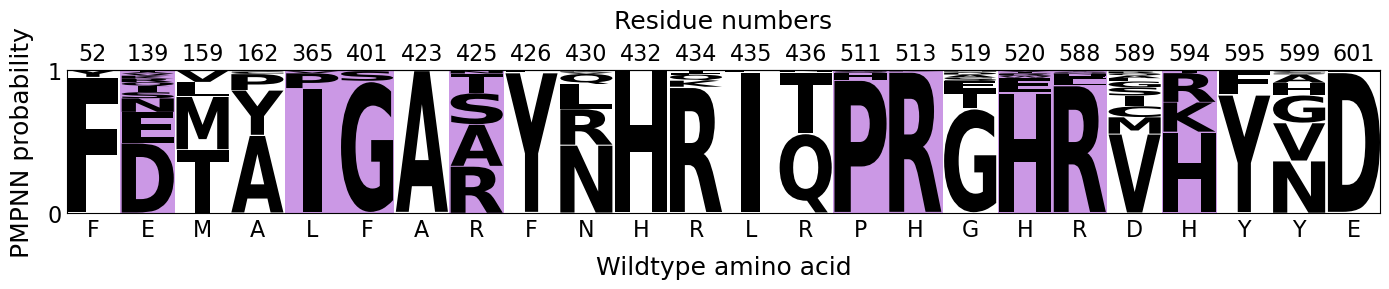

In [24]:
#Code for plotting the probabilities as a logo-plot

import logomaker
import pandas as pd

redmatrix = prob_matrix.mean(0).T.take([i-1 for i in res_selection], axis=1)
df_pmpnn = pd.DataFrame(redmatrix)

aa_list = [char for char in alphabet] #list of all 20 amino acids
df_plot = df_pmpnn.T.set_axis(aa_list, axis=1)

resnames_selection=[pdb_dict_list[0]['seq_chain_A'][i-1] for i in res_selection] #we only want to plot chain A

fig, ax = plt.subplots(figsize=[14,3]) #adjust plotsize if necessary
prob_logo = logomaker.Logo(df_plot,
                           ax=ax,
                           stack_order='small_on_top',
                           color_scheme='black',
                           vpad=.02,
                          )

prob_logo.ax.set_yticks([0, 1])
prob_logo.ax.set_yticklabels(['0', '1'], size=16) #plot probability between 0 and 1
prob_logo.ax.set_xticks(range(len(res_selection))) #set x-labels as the designed residues
prob_logo.ax.set_xticklabels(resnames_selection, size=16) #primary Axis includes amino acid identities
ax.tick_params(axis=u'both', which=u'both',length=0)

#set up secondary axis with numbers of the designed residues
secax = ax.secondary_xaxis('top')
secax.set_xticks(range(len(res_selection)))
secax.set_xticklabels(res_selection, size=16)
secax.tick_params(axis=u'both', which=u'both',length=0)

#set axes' labels
secax.set_xlabel("Residue numbers", size=18, labelpad=10)
ax.set_xlabel("Wildtype amino acid", size=18, labelpad=10)
ax.set_ylabel("PMPNN probability", size=18, labelpad=10)

#highlit a selection of specific residues (violet in Fig2)
pocket = [139, 365, 401, 425, 511, 513, 520, 588, 594]
pocket_idx = [res_selection.index(i) for i in pocket]
notpocket_idx = [i for i in range(len(res_selection)) if i not in pocket_idx]
for i in pocket_idx:
    prob_logo.highlight_position(p=i, color='#9932CC', alpha=.5)
for i in notpocket_idx:
    prob_logo.highlight_position(p=i, color='#FFFFFF', alpha=.5)

fig.tight_layout()
fig.savefig('logo_pmpnn_conditionalprobs_complex.png', dpi=300)

#save all probabilities as csv
column_headers = [j+str(i) for i,j in zip(res_selection,resnames_selection)]

df_writecsv = df_plot.transpose()
df_writecsv.columns = column_headers
df_writecsv.to_csv('pmpnn_complex_prob_table.csv', , format = 'svg', sep=',')